In [1]:
import itertools
import sys, os

import numpy as np
import pandas as pd
from scipy.special import comb
from scipy import stats
import scipy.cluster.hierarchy as hac
import matplotlib.pyplot as plt
plt.style.use('classic')
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
import statsmodels.api as sm

sns.set(rc={'figure.figsize':(15,8)})
sns.set_context('poster')
sns.set_style('white')
#plt.rcParams["figure.dpi"] = 600
from sklearn.model_selection import train_test_split

In [2]:
corder = ['C1', 'C2', 'C3', 'C4', 'C0']

In [3]:
morder = ['MIN', 'OVERFLOW', 'MIXOTROPH', 'EXOENZYME', 'ROS',]
media_order = ['lowN', 'pro99']
mpalette = 'twilight'
sns.color_palette(mpalette, n_colors=5)

[(0.4828677867260272, 0.6304330455306234, 0.761915371498953),
 (0.3668108554010799, 0.26404857724525643, 0.6464799165290824),
 (0.18488035509396164, 0.07942573027972388, 0.21307651648984993),
 (0.5566322903496934, 0.17269677158182117, 0.31423043195101424),
 (0.775907907306857, 0.5355421788246119, 0.42413367909988375)]

In [4]:
gorder = [ 'Strong', 'Sustained', 'Inhibited', 'Weak', 'Axenic',   'Other']
gpalette = sns.color_palette('Set2', n_colors=4).as_hex() + ['black', 'lightgrey']
gpalette = ['#882255', '#CC6677', '#332288', 
             '#44AA99','#88CCEE',
            '#D0CFCA',  ]

sns.color_palette(gpalette)

[(0.5333333333333333, 0.13333333333333333, 0.3333333333333333),
 (0.8, 0.4, 0.4666666666666667),
 (0.2, 0.13333333333333333, 0.5333333333333333),
 (0.26666666666666666, 0.6666666666666666, 0.6),
 (0.5333333333333333, 0.8, 0.9333333333333333),
 (0.8156862745098039, 0.8117647058823529, 0.792156862745098)]

In [5]:
df_predicted_classes = pd.read_csv('monte_het_predicted_classes.csv.gz')

In [ ]:
np.loadtxt()

In [7]:
df_predicted_classes.columns
# ['run_id', 'y_pred', 'max_prob', 'idx', 'media', 'which', 'model','hash']

Index(['run_id', 'y_pred', 'max_prob', 'idx', 'media', 'which', 'model',
       'hash', 'VPRO', 'VPRO_cluster', 'Unnamed: 0', 'Sample', 'full name',
       'Group', 'RMSE_Bptotal[N]', 'RMSE_Bptotal[C]', 'compare_points', 'RMSE',
       'RMSE_filled'],
      dtype='object')

In [8]:
dpath = '../results'
sim_df1 = pd.read_csv(os.path.join(dpath,'monte_het_clean_mse.csv.gz',))
#sim_df2 = pd.read_csv(os.path.join(dpath,'monte2_het_mse.csv.gz',))
mse_df =     sim_df1

# mse_df = pd.concat([
#     sim_df1,
#     sim_df2,
# ])

In [9]:
mse_df.head()

,Unnamed: 0,Sample,full name,Group,RMSE_Bptotal[N],RMSE_Bptotal[C],compare_points,RMSE,run_id
0,0,10A0,Marinovum 5F3,Weak,4.853306,40.918949,74.0,198.592194,monte_MIXOTROPH_39_monte_vpro_34_2_MIXOTROPH_C...
1,1,10B0,Marinovum 5F3,Weak,4.851881,41.073028,74.0,199.281442,monte_MIXOTROPH_39_monte_vpro_34_2_MIXOTROPH_C...
2,2,10C0,Marinovum 5F3,Weak,4.977608,39.177841,74.0,195.011949,monte_MIXOTROPH_39_monte_vpro_34_2_MIXOTROPH_C...
3,3,11A0,Roseovarius 5C3,Weak,4.376933,34.966626,74.0,153.046581,monte_MIXOTROPH_39_monte_vpro_34_2_MIXOTROPH_C...
4,4,11B0,Roseovarius 5C3,Weak,4.683055,37.711511,74.0,176.605068,monte_MIXOTROPH_39_monte_vpro_34_2_MIXOTROPH_C...


In [10]:
mse_df = mse_df.reset_index(drop=True)

In [11]:
min_mse_df = mse_df.loc[mse_df.groupby('run_id')['RMSE'].idxmin()]

In [12]:
del mse_df

In [13]:
min_mse_df.columns, df_predicted_classes.columns

(Index(['Unnamed: 0', 'Sample', 'full name', 'Group', 'RMSE_Bptotal[N]',
        'RMSE_Bptotal[C]', 'compare_points', 'RMSE', 'run_id'],
       dtype='object'),
 Index(['run_id', 'y_pred', 'max_prob', 'idx', 'media', 'which', 'model',
        'hash', 'VPRO', 'VPRO_cluster', 'Unnamed: 0', 'Sample', 'full name',
        'Group', 'RMSE_Bptotal[N]', 'RMSE_Bptotal[C]', 'compare_points', 'RMSE',
        'RMSE_filled'],
       dtype='object'))

In [14]:
df = pd.merge(df_predicted_classes, min_mse_df, on=['run_id'], how='left', suffixes=['', '_min'])

In [15]:
df.columns

Index(['run_id', 'y_pred', 'max_prob', 'idx', 'media', 'which', 'model',
       'hash', 'VPRO', 'VPRO_cluster', 'Unnamed: 0', 'Sample', 'full name',
       'Group', 'RMSE_Bptotal[N]', 'RMSE_Bptotal[C]', 'compare_points', 'RMSE',
       'RMSE_filled', 'Unnamed: 0_min', 'Sample_min', 'full name_min',
       'Group_min', 'RMSE_Bptotal[N]_min', 'RMSE_Bptotal[C]_min',
       'compare_points_min', 'RMSE_min'],
      dtype='object')

In [16]:
min_mse_df['run_id'].value_counts()

run_id
monte_EXOENZYME_100_monte_vpro_11_62_EXOENZYME_C1_29_lowN_all_EXOENZYME_h8519271514136708373           1
monte_OVERFLOW_fix_OVERFLOW_3_monte_vpro_2_99_15_OVERFLOW_56_lowN_all_OVERFLOW_h6878164821315599434    1
monte_OVERFLOW_fix_OVERFLOW_3_monte_vpro_2_31_17_OVERFLOW_73_lowN_all_OVERFLOW_h6878164821315599434    1
monte_OVERFLOW_fix_OVERFLOW_3_monte_vpro_2_32_57_OVERFLOW_94_lowN_all_OVERFLOW_h6878164821315599434    1
monte_OVERFLOW_fix_OVERFLOW_3_monte_vpro_2_34_47_OVERFLOW_15_lowN_all_OVERFLOW_h6878164821315599434    1
                                                                                                      ..
monte_MIN_6_monte_vpro_71_74_MIN_C2_21_lowN_all_MIN_h-1541717058758371284                              1
monte_MIN_6_monte_vpro_71_74_MIN_C2_79_lowN_all_MIN_h-1541717058758371284                              1
monte_MIN_6_monte_vpro_75_4_MIN_C1_24_lowN_all_MIN_h-1541717058758371284                               1
monte_MIN_6_monte_vpro_75_4_MIN_C1_31_lowN_all_M

In [17]:
#df_predicted_classes.shape, 
min_mse_df.shape, df.shape

((49298, 9), (49298, 27))

In [18]:
df.head()

,run_id,y_pred,max_prob,idx,media,which,model,hash,VPRO,VPRO_cluster,...,RMSE,RMSE_filled,Unnamed: 0_min,Sample_min,full name_min,Group_min,RMSE_Bptotal[N]_min,RMSE_Bptotal[C]_min,compare_points_min,RMSE_min
0,monte_EXOENZYME_100_monte_vpro_11_62_EXOENZYME...,Sustained,0.974799,monte_EXOENZYME_100_monte_vpro_11_62_EXOENZYME...,lowN,all,EXOENZYME,h8519271514136708373,vpro_11_62_EXOENZYME_C1,C1,...,261.836489,261.836489,1093601,10C0,Marinovum 5F3,Weak,4.328551,45.455198,74.0,196.755133
1,monte_EXOENZYME_100_monte_vpro_12_88_EXOENZYME...,Weak,0.902784,monte_EXOENZYME_100_monte_vpro_12_88_EXOENZYME...,lowN,all,EXOENZYME,h8519271514136708373,vpro_12_88_EXOENZYME_C2,C2,...,139.956662,139.956662,150894,11A0,Roseovarius 5C3,Weak,4.621448,30.284159,74.0,139.956662
2,monte_EXOENZYME_100_monte_vpro_13_4_EXOENZYME_...,Axenic,0.986157,monte_EXOENZYME_100_monte_vpro_13_4_EXOENZYME_...,lowN,all,EXOENZYME,h8519271514136708373,vpro_13_4_EXOENZYME_C3,C3,...,121.942887,121.942887,72313,1B0,Axenic,Axenic,2.342476,52.057268,74.0,121.942887
3,monte_EXOENZYME_100_monte_vpro_13_4_EXOENZYME_...,Axenic,0.986658,monte_EXOENZYME_100_monte_vpro_13_4_EXOENZYME_...,lowN,all,EXOENZYME,h8519271514136708373,vpro_13_4_EXOENZYME_C3,C3,...,102.358629,102.358629,591130,1B0,Axenic,Axenic,2.137782,47.880754,74.0,102.358629
4,monte_EXOENZYME_100_monte_vpro_13_69_EXOENZYME...,Axenic,0.978219,monte_EXOENZYME_100_monte_vpro_13_69_EXOENZYME...,lowN,all,EXOENZYME,h8519271514136708373,vpro_13_69_EXOENZYME_C1,C1,...,762.999051,762.999051,362035,7B0,Sulfitobacter pseudonitzschiae,Sustained,2.548766,24.861325,74.0,63.365700


In [19]:
df['RMSE'] = np.sqrt(df['RMSE'])

In [20]:
df.shape

(49298, 27)

In [21]:
df[['Group']].value_counts().reset_index()

,Group,count
0,Weak,26093
1,Axenic,18589
2,Sustained,2644
3,Strong,272
4,Inhibited,49


In [22]:
df[['Group', 'Group_min']].value_counts() / 493.49

Group      Group_min
Weak       Weak         44.880342
Axenic     Axenic       27.540578
Weak       Axenic        6.577641
Axenic     Sustained     5.491499
           Weak          4.630286
Sustained  Axenic        3.461063
Weak       Sustained     1.390099
Sustained  Sustained     0.849055
           Weak          0.682891
Strong     Strong        0.453910
Sustained  Strong        0.364749
Strong     Axenic        0.097266
Inhibited  Weak          0.079029
Weak       Inhibited     0.026343
Inhibited  Sustained     0.012158
           Inhibited     0.008106
Axenic     Strong        0.006079
Name: count, dtype: float64

In [23]:
12/49349

0.00024316602160124825

In [24]:
df[['Group','model']].value_counts().reset_index()

,Group,model,count
0,Weak,ROS,8039
1,Weak,MIN,6571
2,Weak,MIXOTROPH,5569
3,Axenic,OVERFLOW,5370
4,Axenic,EXOENZYME,4324
5,Axenic,MIXOTROPH,4290
6,Weak,OVERFLOW,3832
7,Axenic,MIN,3291
8,Sustained,EXOENZYME,2391
9,Weak,EXOENZYME,2082


In [25]:
df['full name'].value_counts()

full name
Axenic                            18589
Marinovum 5F3                     16090
Roseovarius 5C3                   10003
Sulfitobacter pseudonitzschiae     2303
Ruegeria pomeroyi                   341
A. macleodii ATCC27126              225
Pseudoalteromonas haloplanktis       47
Marinobacter adhaerens HP15          41
Phaeobacter gallaeciensis             8
Name: count, dtype: int64

In [26]:
df['RMSE'].describe()

count    47647.000000
mean        14.982583
std          7.887221
min          0.896181
25%          9.274116
50%         13.174930
75%         19.241289
max         76.875352
Name: RMSE, dtype: float64

In [27]:
df.nlargest(10, 'RMSE')

,run_id,y_pred,max_prob,idx,media,which,model,hash,VPRO,VPRO_cluster,...,RMSE,RMSE_filled,Unnamed: 0_min,Sample_min,full name_min,Group_min,RMSE_Bptotal[N]_min,RMSE_Bptotal[C]_min,compare_points_min,RMSE_min
44862,monte_ROS_5_monte_vpro_19_33_ROS_C0_70_lowN_al...,Strong,0.982631,monte_ROS_5_monte_vpro_19_33_ROS_C0_70,lowN,all,ROS,h-8660846992299669535,vpro_19_33_ROS_C0,C0,...,76.875352,5909.819710,79821,5x5_21A0,A. macleodii ATCC27126,Strong,22.790988,259.305117,74.0,5909.819710
47718,monte_ROS_86_monte_vpro_19_33_ROS_C0_32_lowN_a...,Strong,0.980648,monte_ROS_86_monte_vpro_19_33_ROS_C0_32,lowN,all,ROS,h-8660846992299669535,vpro_19_33_ROS_C0,C0,...,75.697766,5730.151801,180441,5x5_21A0,A. macleodii ATCC27126,Strong,22.412984,255.662160,74.0,5730.151801
39728,monte_ROS_12_monte_vpro_19_33_ROS_C0_16_lowN_a...,Strong,0.980645,monte_ROS_12_monte_vpro_19_33_ROS_C0_16,lowN,all,ROS,h-8660846992299669535,vpro_19_33_ROS_C0,C0,...,74.791223,5593.726984,362454,5x5_21A0,A. macleodii ATCC27126,Strong,22.176763,252.233695,74.0,5593.726984
43387,monte_ROS_46_monte_vpro_19_33_ROS_C0_32_lowN_a...,Strong,0.984394,monte_ROS_46_monte_vpro_19_33_ROS_C0_32,lowN,all,ROS,h-8660846992299669535,vpro_19_33_ROS_C0,C0,...,73.593628,5416.022114,1300716,5x5_21A0,A. macleodii ATCC27126,Strong,21.885008,247.476358,74.0,5416.022114
45255,monte_ROS_63_monte_vpro_19_33_ROS_C0_99_lowN_a...,Strong,0.980637,monte_ROS_63_monte_vpro_19_33_ROS_C0_99,lowN,all,ROS,h-8660846992299669535,vpro_19_33_ROS_C0,C0,...,73.047991,5336.008981,436359,5x5_21A0,A. macleodii ATCC27126,Strong,21.687178,246.044411,74.0,5336.008981
45454,monte_ROS_65_monte_vpro_19_33_ROS_C0_88_lowN_a...,Strong,0.987394,monte_ROS_65_monte_vpro_19_33_ROS_C0_88,lowN,all,ROS,h-8660846992299669535,vpro_19_33_ROS_C0,C0,...,71.766327,5150.405708,1438152,5x5_21A0,A. macleodii ATCC27126,Strong,21.474462,239.838642,74.0,5150.405708
45060,monte_ROS_61_monte_vpro_19_33_ROS_C0_77_lowN_a...,Strong,0.980629,monte_ROS_61_monte_vpro_19_33_ROS_C0_77,lowN,all,ROS,h-8660846992299669535,vpro_19_33_ROS_C0,C0,...,71.153587,5062.832973,478479,5x5_21A0,A. macleodii ATCC27126,Strong,21.261127,238.126275,74.0,5062.832973
39923,monte_ROS_14_monte_vpro_19_33_ROS_C0_94_lowN_a...,Strong,0.980626,monte_ROS_14_monte_vpro_19_33_ROS_C0_94,lowN,all,ROS,h-8660846992299669535,vpro_19_33_ROS_C0,C0,...,70.750187,5005.588949,1412451,5x5_21A0,A. macleodii ATCC27126,Strong,21.162298,236.533335,74.0,5005.588949
42394,monte_ROS_37_monte_vpro_19_33_ROS_C0_85_lowN_a...,Strong,0.982600,monte_ROS_37_monte_vpro_19_33_ROS_C0_85,lowN,all,ROS,h-8660846992299669535,vpro_19_33_ROS_C0,C0,...,69.570366,4840.035817,436086,5x5_21A0,A. macleodii ATCC27126,Strong,20.852508,232.108092,74.0,4840.035817
47823,monte_ROS_87_monte_vpro_19_33_ROS_C0_94_lowN_a...,Strong,0.987382,monte_ROS_87_monte_vpro_19_33_ROS_C0_94,lowN,all,ROS,h-8660846992299669535,vpro_19_33_ROS_C0,C0,...,69.493213,4829.306646,827295,5x5_21A0,A. macleodii ATCC27126,Strong,20.991931,230.055376,74.0,4829.306646


(array([0.5, 1.5, 2.5, 3.5, 4.5]),
 [Text(0, 0.5, 'Axenic'),
  Text(0, 1.5, 'Inhibited'),
  Text(0, 2.5, 'Strong'),
  Text(0, 3.5, 'Sustained'),
  Text(0, 4.5, 'Weak')])

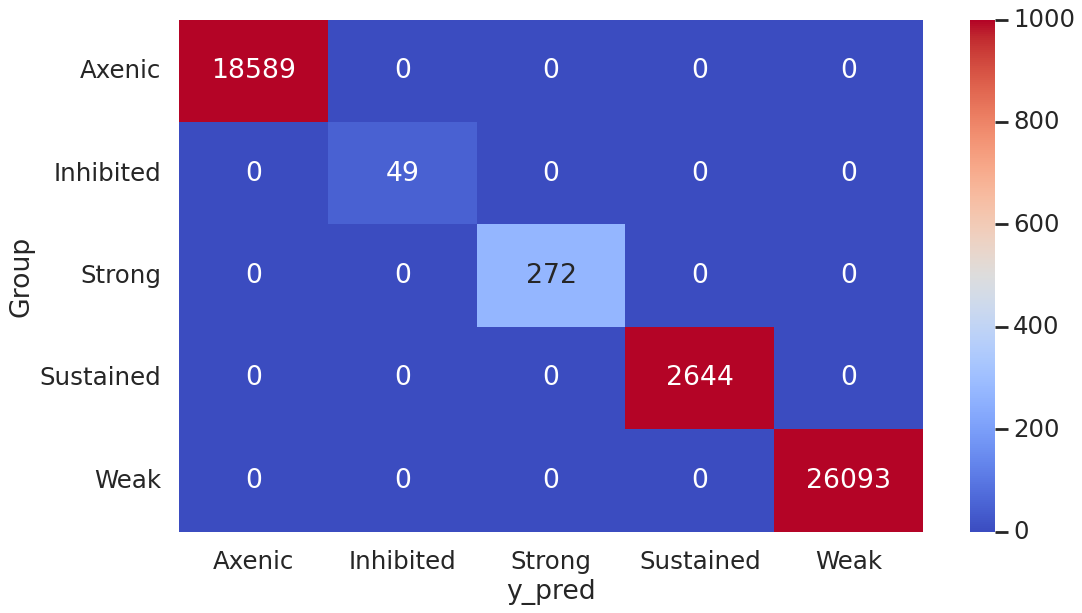

In [28]:
sns.heatmap(
    df[['Group', 'y_pred']].value_counts().reset_index().pivot(index='Group', columns='y_pred').fillna(0).droplevel(0, axis=1),
    cmap='coolwarm', 
    annot=True, fmt='.0f', vmax=1000
)
plt.yticks(rotation=0) 

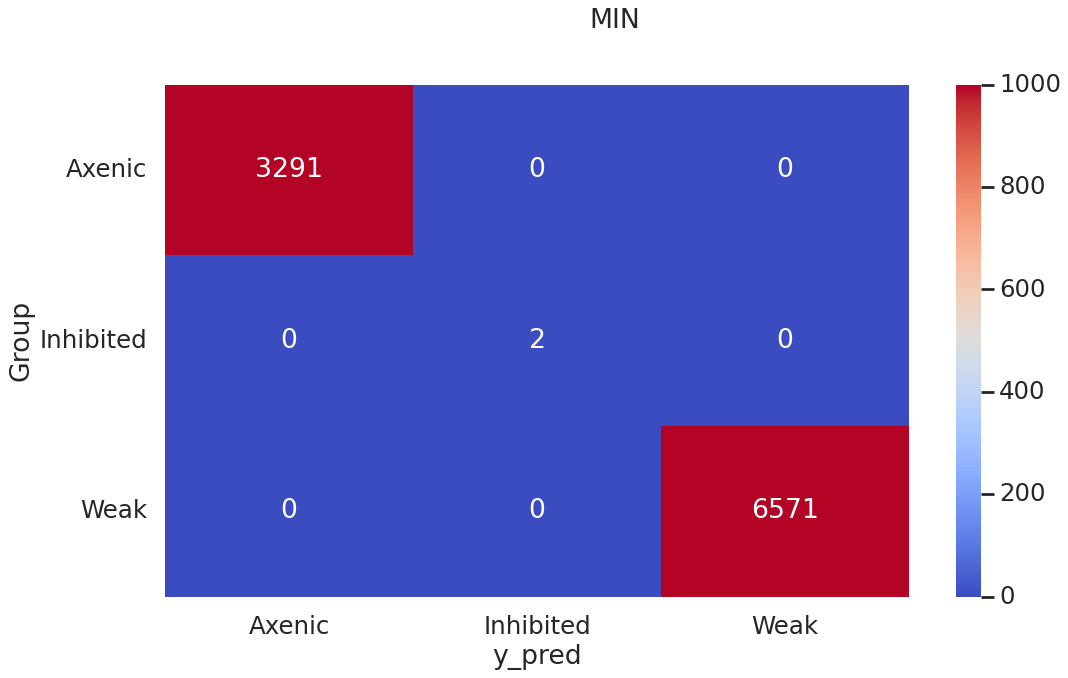

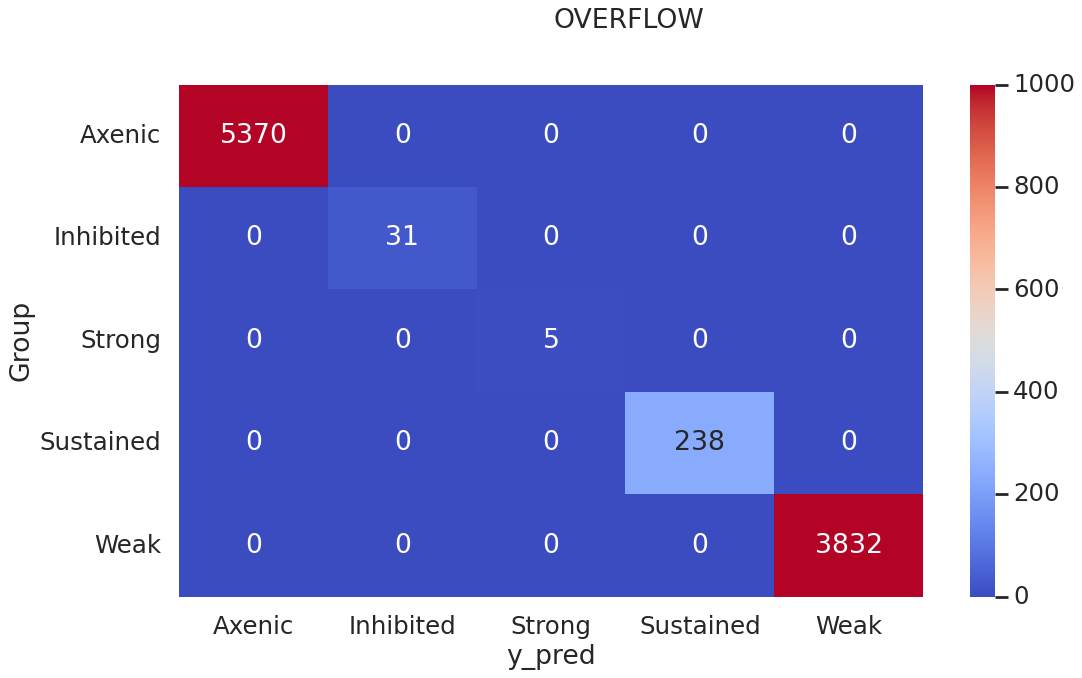

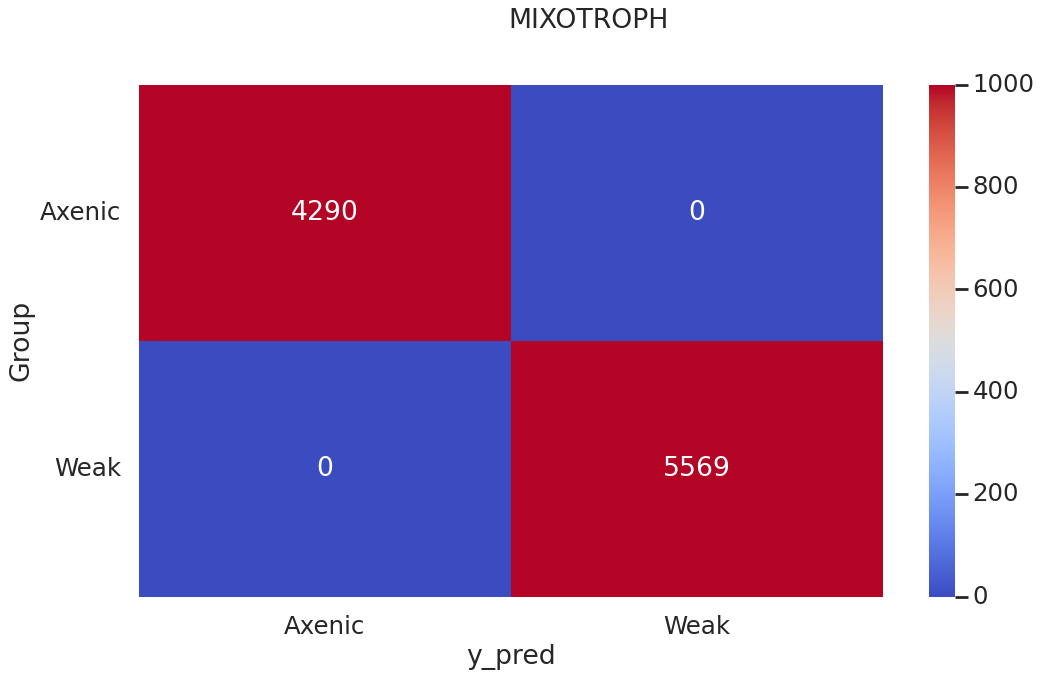

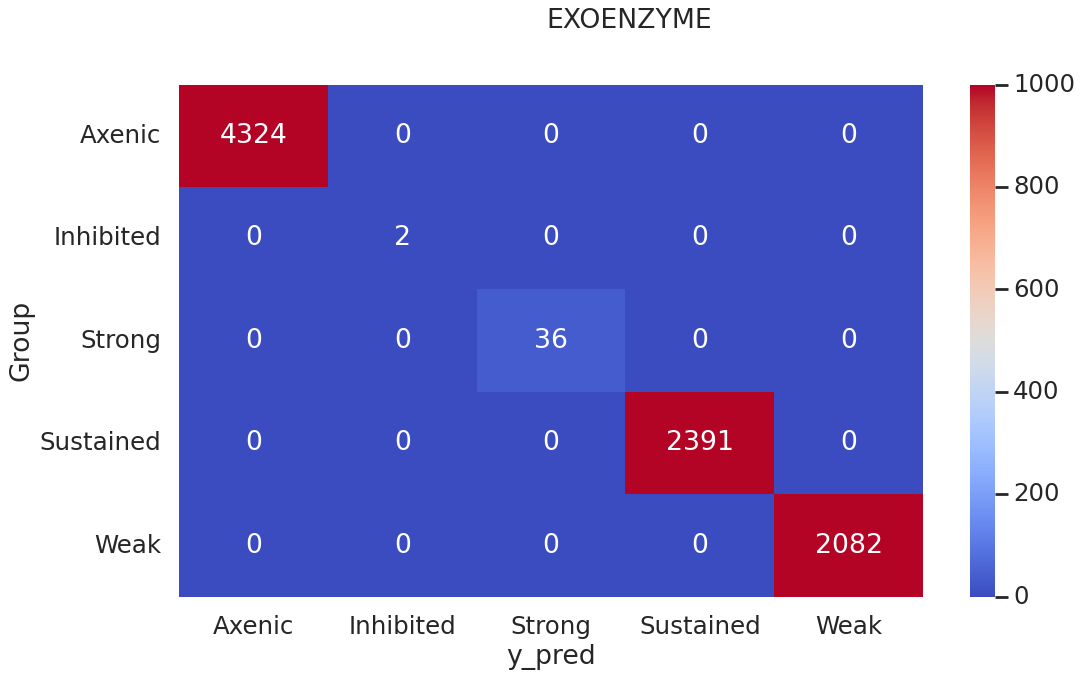

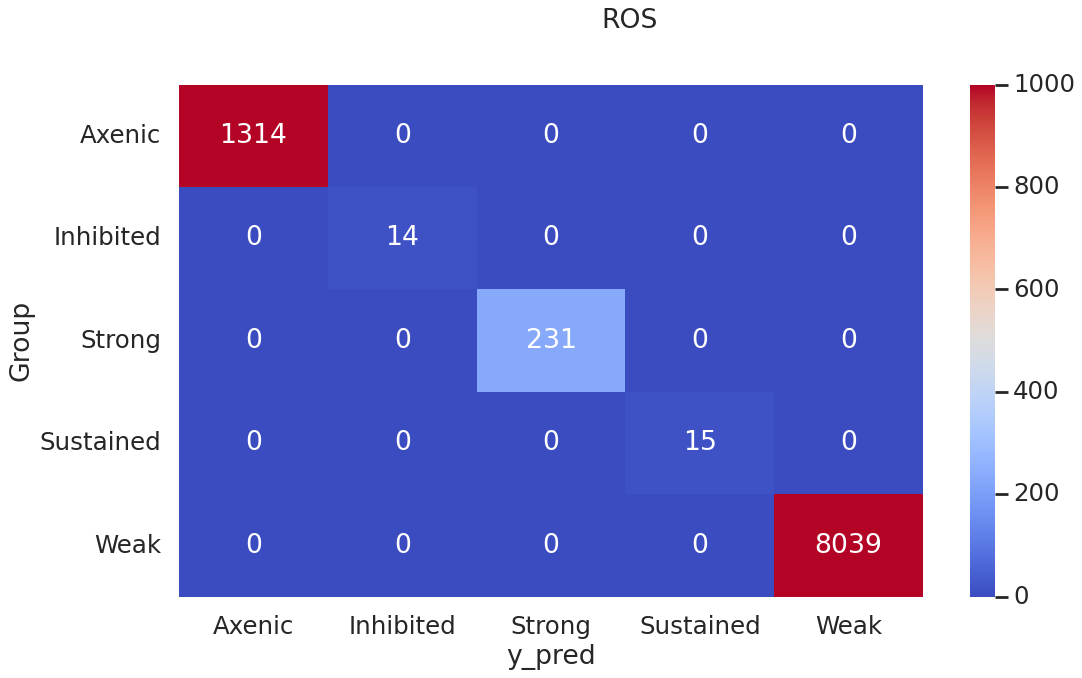

In [29]:
for m in morder:
    sns.heatmap(
        df.loc[df.model.isin([m]),['Group', 'y_pred']].value_counts().reset_index().pivot(index='Group', columns='y_pred').fillna(0).droplevel(0, axis=1),
        cmap='coolwarm', 
        annot=True, fmt='.0f', vmax=1000
    )
    plt.yticks(rotation=0) 
    plt.suptitle(m, y=1.02)
    plt.show()

In [30]:
df[['Group', 'y_pred']].value_counts().reset_index().pivot(index='Group', columns='y_pred').droplevel(0, axis=1).columns


Index(['Axenic', 'Inhibited', 'Strong', 'Sustained', 'Weak'], dtype='object', name='y_pred')

In [31]:
df['RMSE_clip'] = df.RMSE.clip(upper=100)

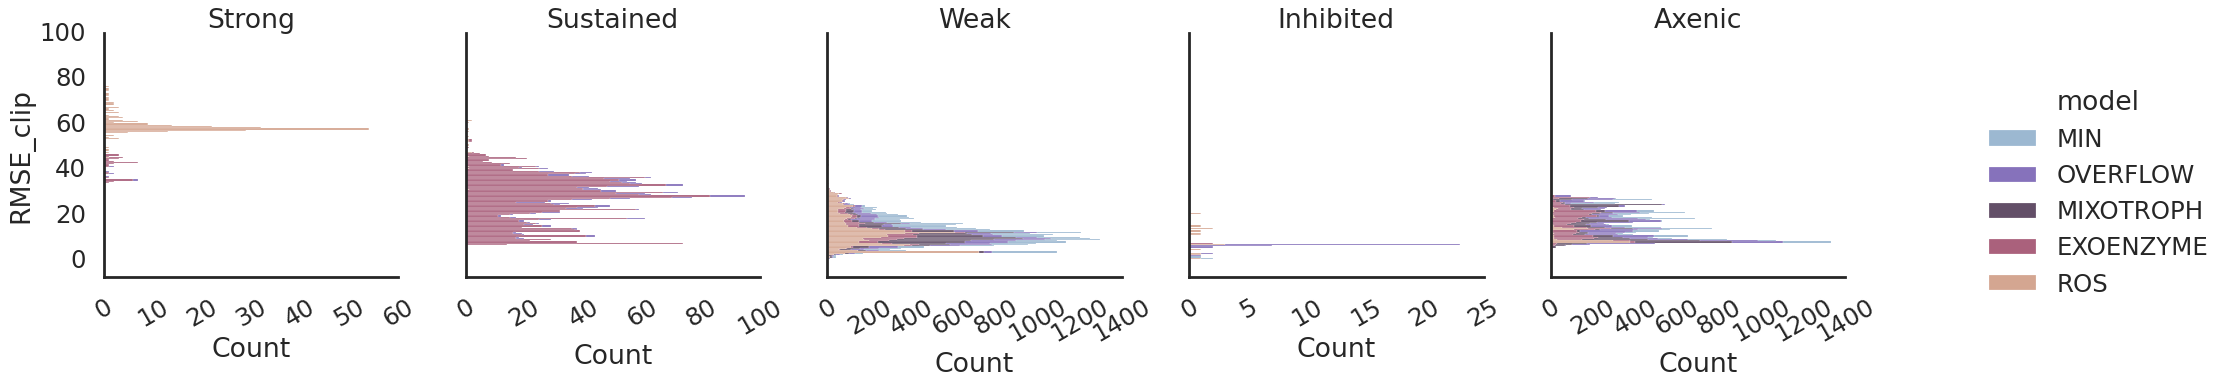

In [32]:
g = sns.displot(
    data=df,
    #col='y_pred', 
    col='Group', col_order=gorder[:-1],
    y='RMSE_clip',
    facet_kws=dict(sharex=False,margin_titles=True),
    #row='model',
    palette=mpalette, hue='model', hue_order=morder, multiple='stack',

)
g.set_titles(col_template='{col_name}', row_template='{row_name}')
g.set_xticklabels(rotation=30)
g.set(ylim=(-7,100))
#g.set(yscale='log')

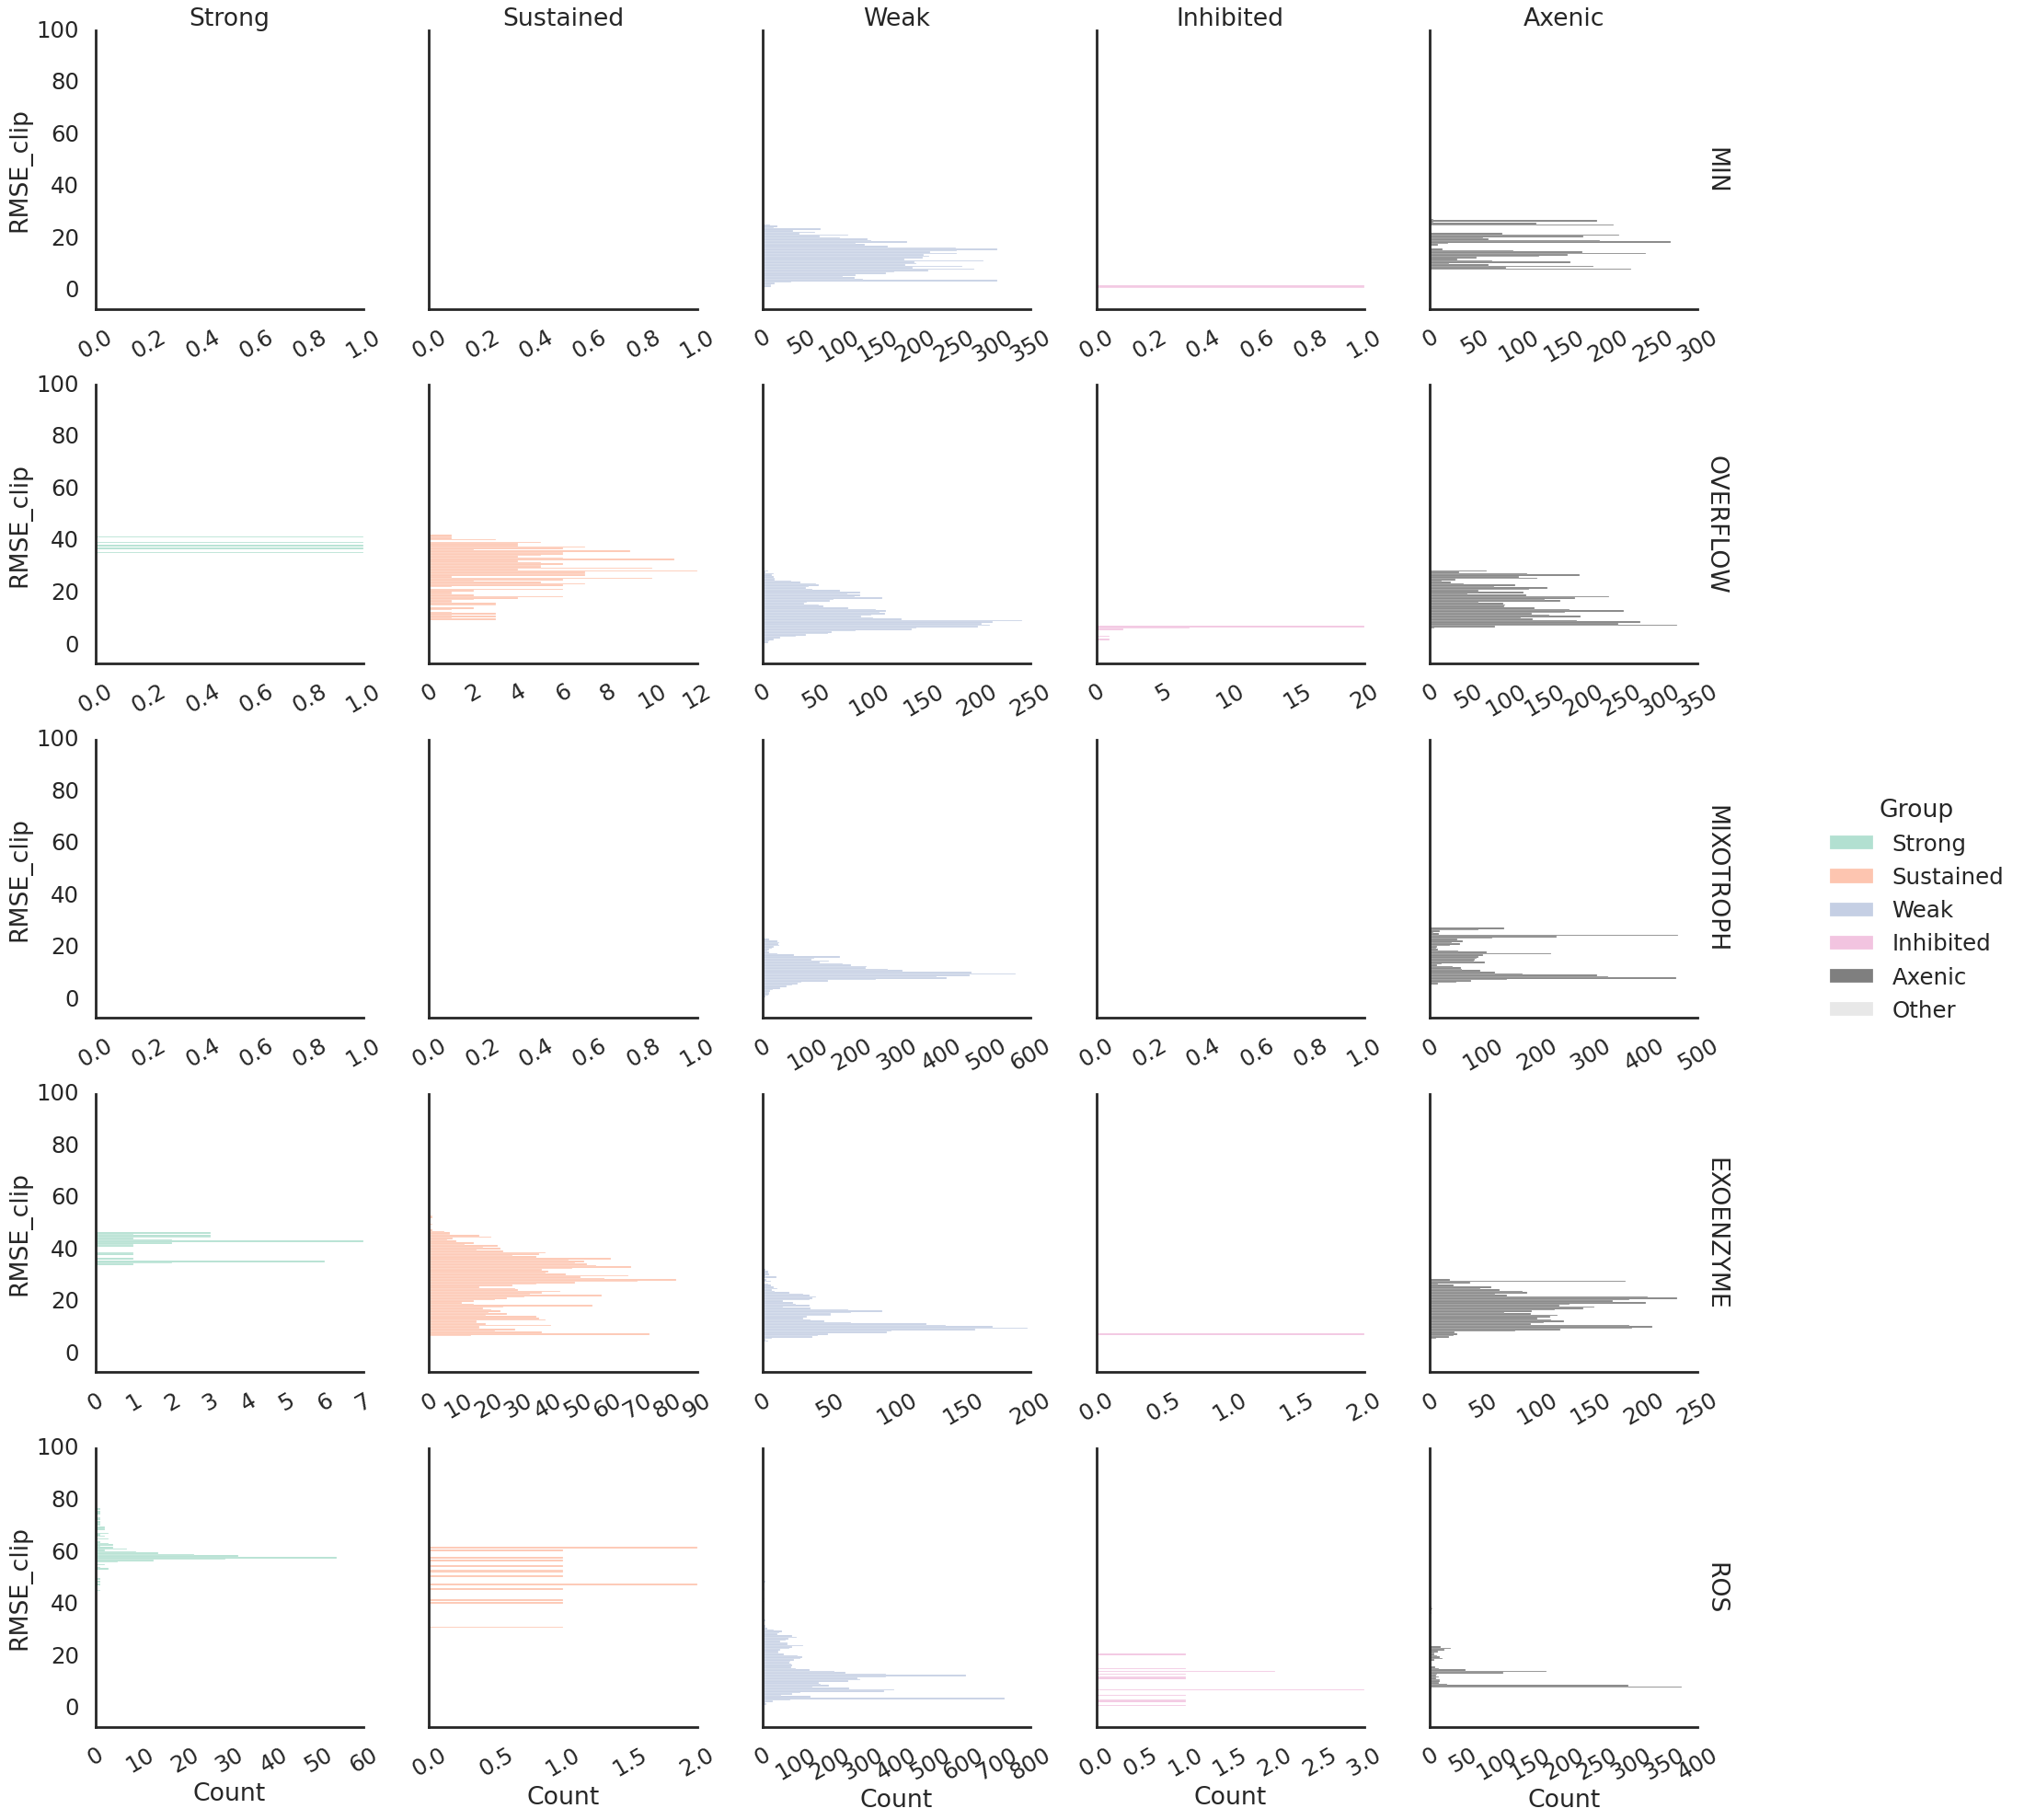

In [33]:
g = sns.displot(
    data=df,
    row='model', row_order=morder, 
    col='Group', col_order=gorder[:-1],
    #palette=mpalette, hue='model', hue_order=morder,
    palette=gpalette, hue='Group', hue_order=gorder,
    
    y='RMSE_clip', #log_scale=True,
    facet_kws=dict(sharex=False, margin_titles=True), #sharey=False,
    #row='model',
    

)
g.set_titles(col_template='{col_name}', row_template='{row_name}')
g.set(ylim=(-7,100))
g.set_xticklabels(rotation=30)

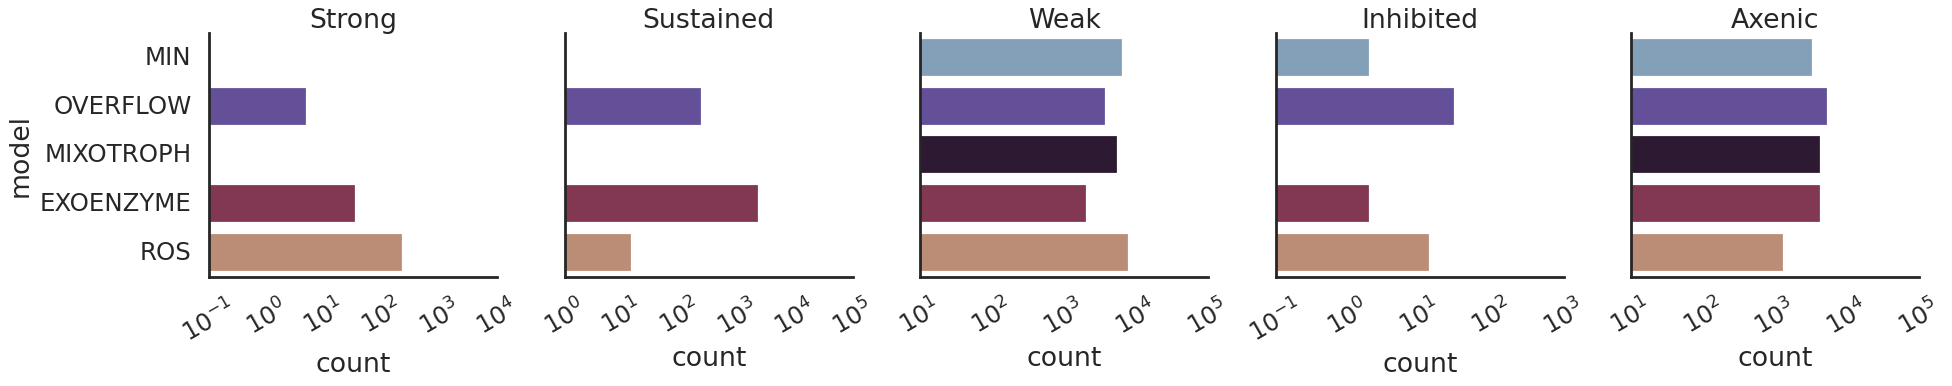

In [36]:
g = sns.catplot(
    data=df,
    y='model', order=morder, 
    col='Group', col_order=gorder[:-1],
    palette=mpalette, hue='model', hue_order=morder, dodge=False,
    kind='count',
    margin_titles=True,
    sharex=False,
    #col_wrap=3,
    legend=False,
    #aspect=2,
)
g.set_titles(col_template='{col_name}', row_template='{row_name}')
g.set(xscale='log')
g.set_xticklabels(rotation=30)

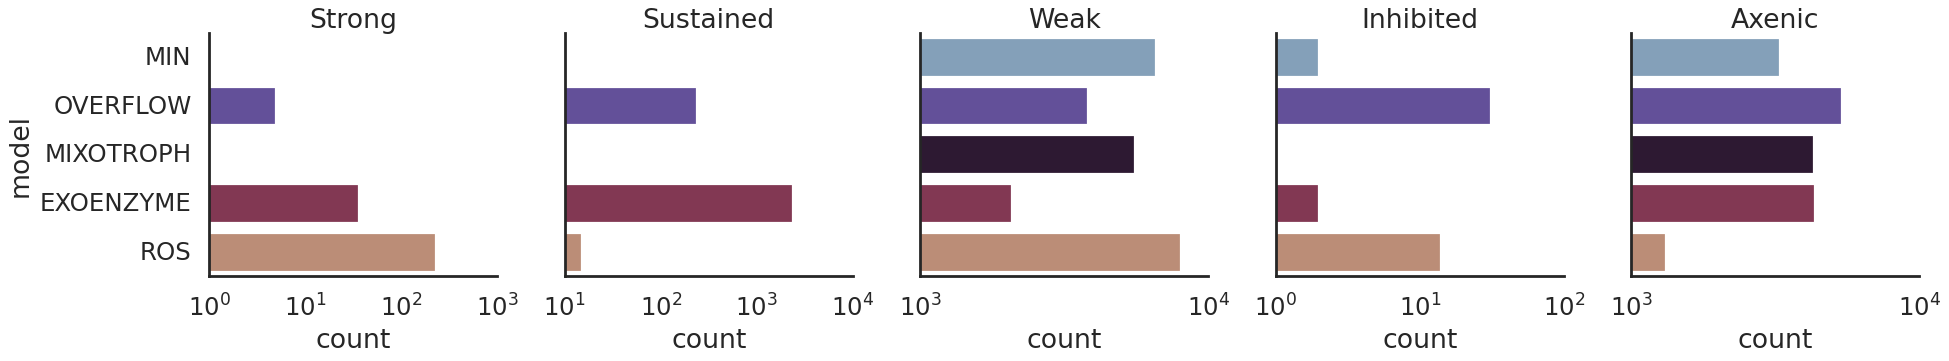

In [38]:
g = sns.catplot(
    data=df,
    y='model', order=morder, 
    col='Group', col_order=gorder[:-1],
    palette=mpalette, hue='model', hue_order=morder, dodge=False,
    kind='count',
    sharex=False, margin_titles=True,
    #col_wrap=3,
    legend=False,
    #aspect=2,
)
g.set_titles(col_template='{col_name}', row_template='{row_name}')
g.set(xscale='log')
#g.set_xticklabels(rotation=30)

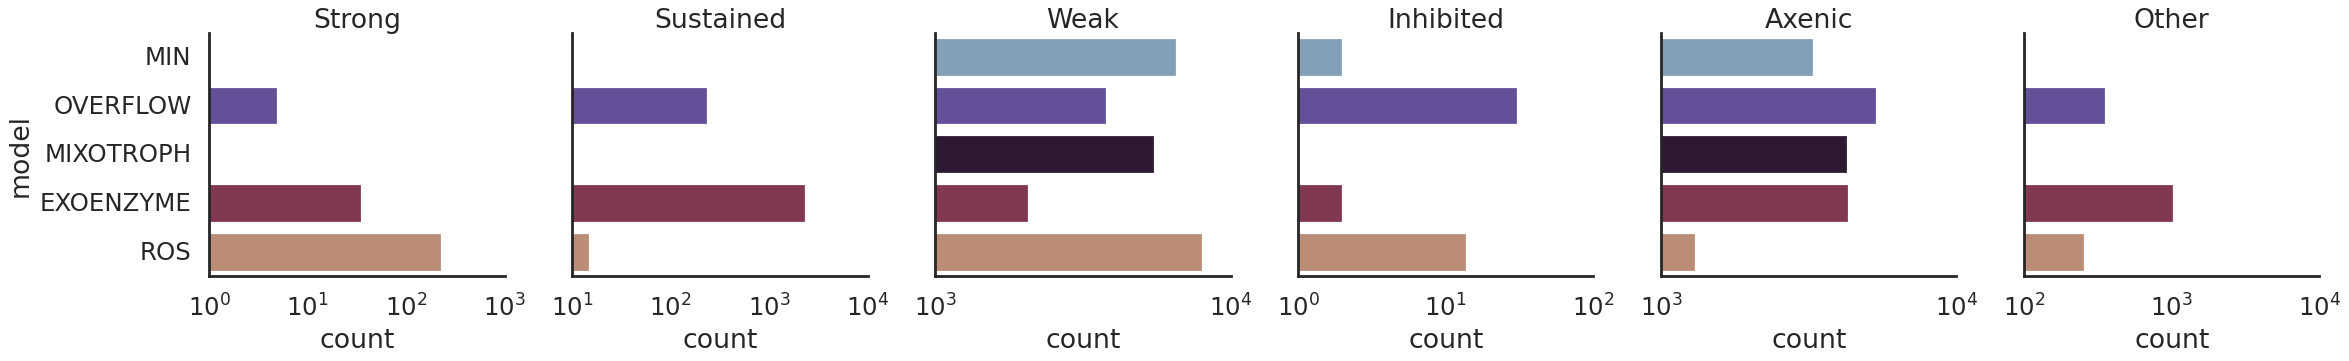

In [39]:
g = sns.catplot(
    data=df,
    y='model', order=morder, 
    col='y_pred', col_order=gorder,
    palette=mpalette, hue='model', hue_order=morder, dodge=False,
    kind='count',
     margin_titles=True,
    sharex=False,
    #col_wrap=3,
    legend=False,
    #aspect=2,
)
g.set_titles(col_template='{col_name}', row_template='{row_name}')
g.set(xscale='log')
#g.set_xticklabels(rotation=30)

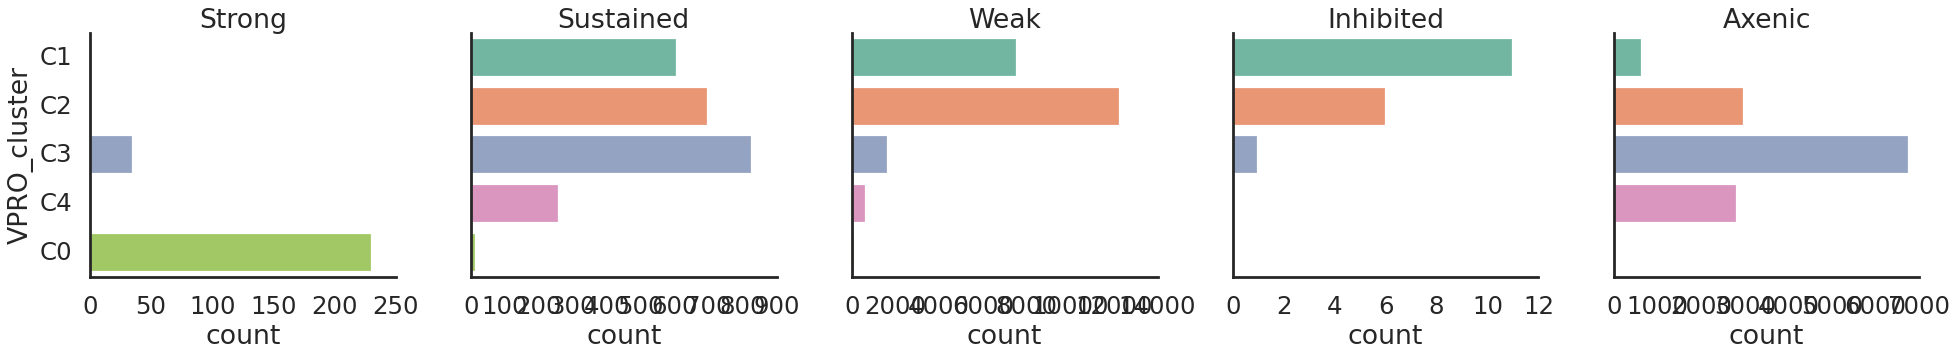

In [40]:
g = sns.catplot(
    data=df,
    y='VPRO_cluster', order=corder, 
    col='Group', col_order=gorder[:-1],
    palette='Set2', hue='VPRO_cluster', hue_order=corder, dodge=False,
    kind='count',
     margin_titles=True,
    sharex=False,
    #col_wrap=3,
    legend=False,
    #aspect=2,
)
g.set_titles(col_template='{col_name}', row_template='{row_name}')
#g.set(xscale='log')
#g.set_xticklabels(rotation=30)

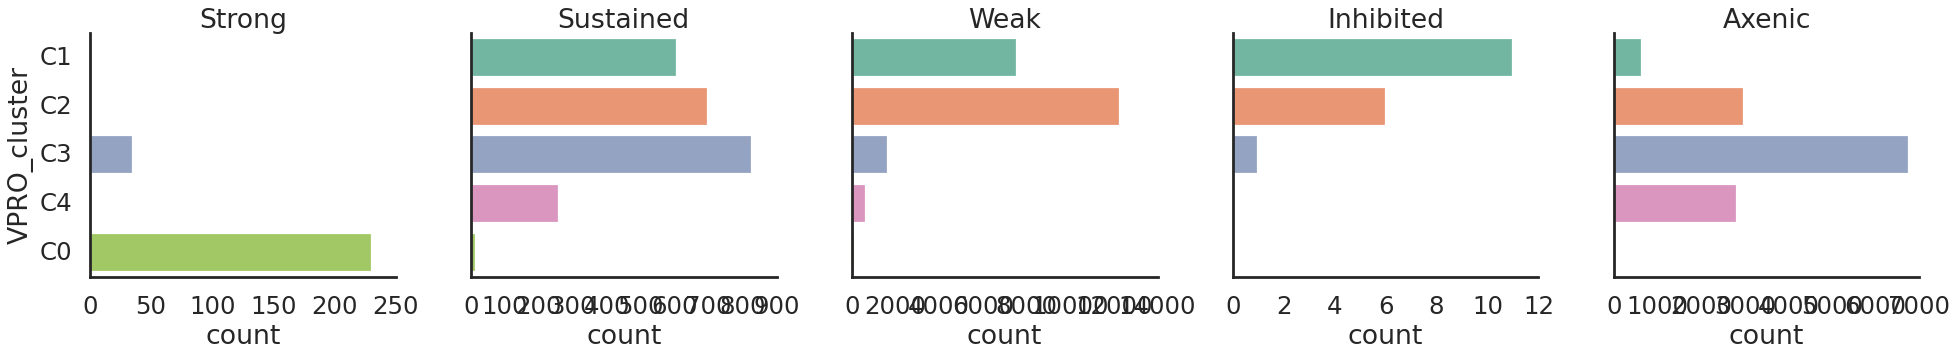

In [41]:
g = sns.catplot(
    data=df,
    y='VPRO_cluster', order=corder, 
    col='y_pred', col_order=gorder[:-1],
    palette='Set2', hue='VPRO_cluster', hue_order=corder, dodge=False,
    kind='count',
     margin_titles=True,
    sharex=False,
    #col_wrap=3,
    legend=False,
    #aspect=2,
)
g.set_titles(col_template='{col_name}', row_template='{row_name}')
#g.set(xscale='log')
#g.set_xticklabels(rotation=30)

In [42]:
df.pivot_table(index='model', columns='Group', values='run_id', aggfunc='count', fill_value=0).reindex(index=morder, columns=gorder[:-1])

Group,Strong,Sustained,Weak,Inhibited,Axenic
model,,,,,
MIN,0,0,6571,2,3291
OVERFLOW,5,238,3832,31,5370
MIXOTROPH,0,0,5569,0,4290
EXOENZYME,36,2391,2082,2,4324
ROS,231,15,8039,14,1314


In [43]:
pdf = df.pivot_table(index='model', columns='y_pred', values='run_id', aggfunc='count', fill_value=0).reindex(index=morder, columns=gorder)
pdf

y_pred,Strong,Sustained,Weak,Inhibited,Axenic,Other
model,,,,,,
MIN,0,0,6571,2,3291,0
OVERFLOW,5,238,3832,31,5370,359
MIXOTROPH,0,0,5569,0,4290,0
EXOENZYME,36,2391,2082,2,4324,1033
ROS,231,15,8039,14,1314,259


In [52]:
pdf.T['MIN']

y_pred
Strong          0
Sustained       0
Weak         6571
Inhibited       2
Axenic       3291
Other           0
Name: MIN, dtype: int64

In [57]:
pdf.rename(columns={'Axenic':'Neutral'}, inplace=True)

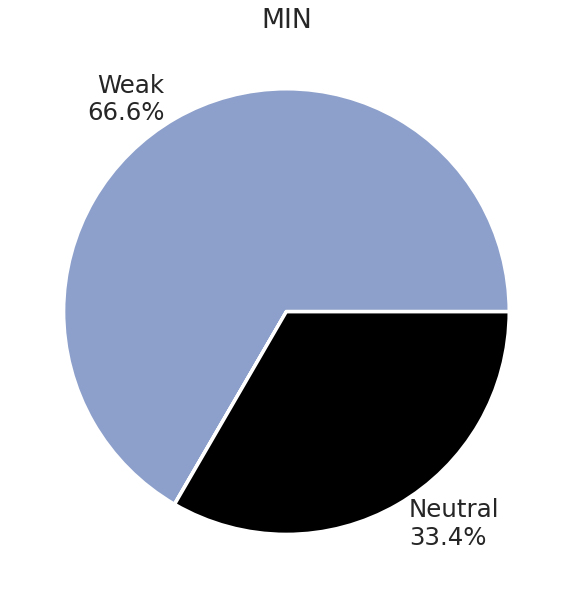

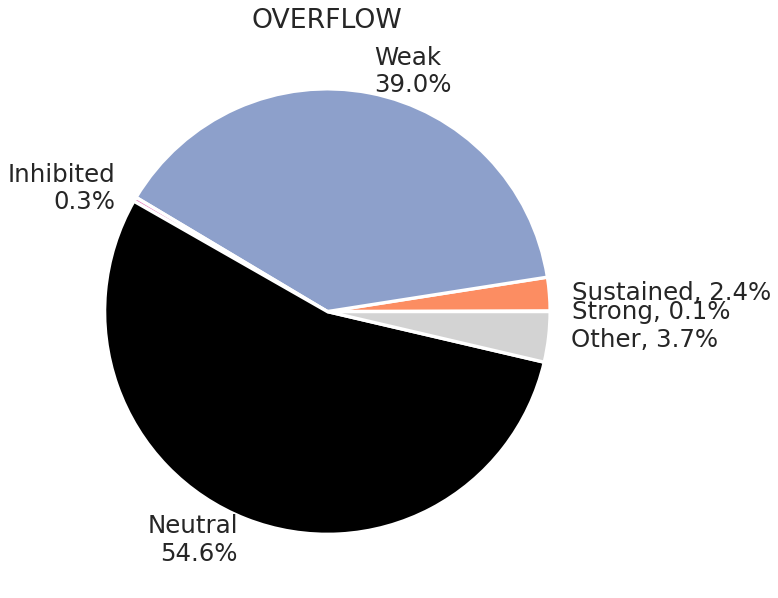

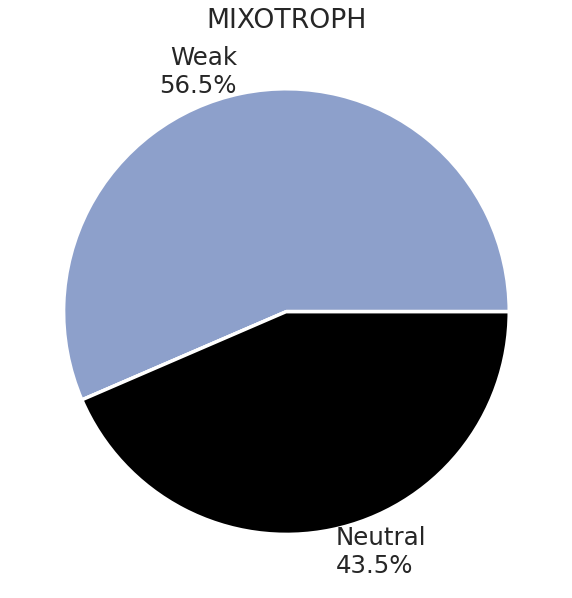

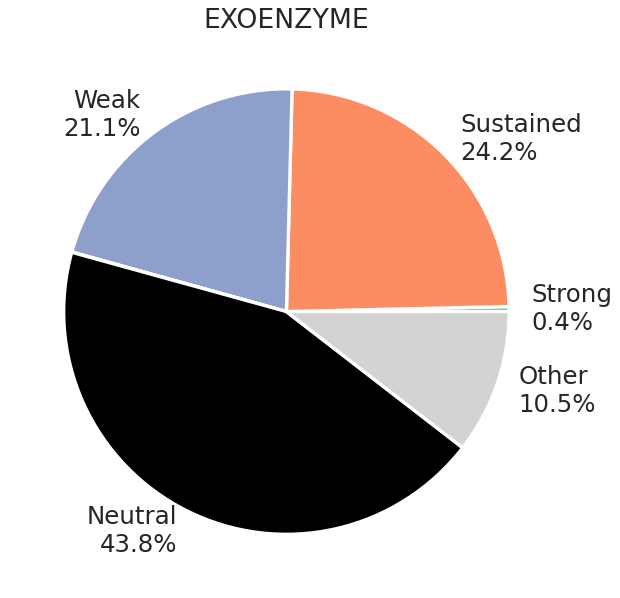

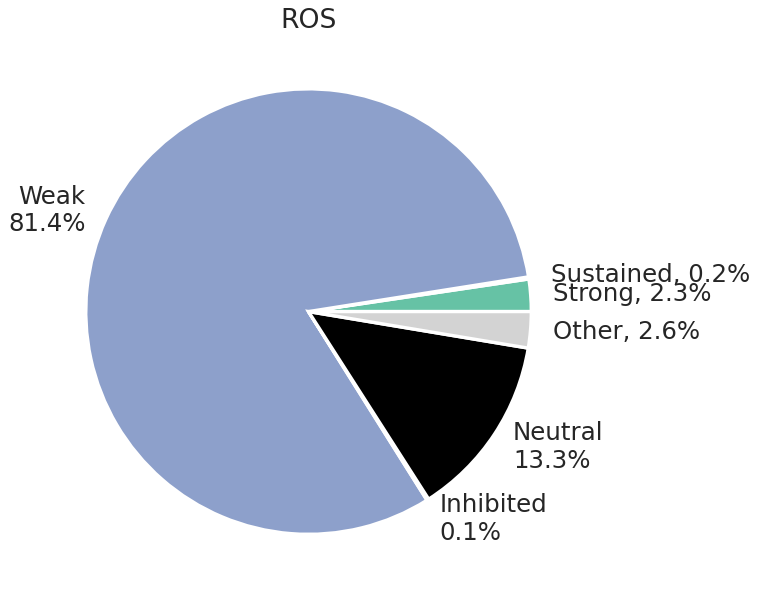

In [58]:
for m in morder:
    fig, ax = plt.subplots()

    _wedges, labels, percentages = ax.pie(pdf.T[m], labels=pdf.columns, autopct='%1.1f%%', colors=gpalette,
       wedgeprops={'linewidth': 3.0, 'edgecolor': 'white'},
          )
    for label, percentage in zip(labels, percentages):
        if percentage.get_text() == '0.0%':
            percentage.remove()
            label.remove()
        else:
            if m in ['OVERFLOW', 'ROS'] and label.get_text() in ['Sustained', 'Strong', 'Other']:
                label.set_text(label.get_text() + ', ' + percentage.get_text())
            else:
                label.set_text(label.get_text() + '\n' + percentage.get_text())
            percentage.remove()
    plt.title(m)
    plt.tight_layout()
    plt.show()

In [45]:
ppdf = pdf.div(pdf.sum(axis=1), axis=0) *100
ppdf

y_pred,Strong,Sustained,Weak,Inhibited,Axenic,Other
model,,,,,,
MIN,0.000000,0.000000,66.615977,0.020276,33.363747,0.000000
OVERFLOW,0.050839,2.419929,38.962888,0.315201,54.600915,3.650229
MIXOTROPH,0.000000,0.000000,56.486459,0.000000,43.513541,0.000000
EXOENZYME,0.364816,24.229834,21.098500,0.020268,43.818403,10.468180
ROS,2.339951,0.151945,81.432334,0.141815,13.310373,2.623582


In [ ]:
df.pivot_table(index=['VPRO_cluster'], columns='Group', values='run_id', aggfunc='count', fill_value=0).reindex( columns=gorder[:-1])

In [ ]:
df.pivot_table(index=['VPRO_cluster'], columns='y_pred', values='run_id', aggfunc='count', fill_value=0).reindex( columns=gorder)

In [ ]:
df.VPRO_cluster.value_counts()

In [ ]:
morder

In [ ]:
fig, axs = plt.subplots(5, 5, sharey=True)
for i,m in enumerate(morder):
    for j,c in enumerate(['C1', 'C2', 'C3', 'C4', 'C0']):
        t = df.loc[
            df.model.isin([m]) & df.VPRO_cluster.isin([c])
            #df.Group.isin(glist)
        ].copy()
        if t.shape[0]>0:
            tnumdf = t.pivot_table(
                index='VPRO', columns='Group', values='model', aggfunc='count', fill_value=0
            ).reindex(columns=gorder[:-1])
            #tnumdf['total'] = tnumdf.sum(axis=1)        
            tnumdf = tnumdf.sort_values(by=list(reversed(tnumdf.columns.to_list())))
            t['VPRO_'] = pd.Categorical(t['VPRO'], reversed(tnumdf.index))
            g = sns.histplot(
                data=t, lw=0.3,
                hue='Group', x='VPRO_',  discrete=True, multiple='stack',
                hue_order=gorder, palette=gpalette,
                ax=axs[j,i], 
                #aspect=1,
                legend=False,
                       )
        axs[i,j].set_xticks([])
        axs[i,j].set_yticks([0,200,400])
        axs[i,j].set_xlabel('')
            
            #g.set(xticklabels=[])
            #g.set_titles(col_template='{col_name}', row_template='{row_name}')
            #axs[i,j].set_title(f'{m} {c}')
plt.show()


In [ ]:
fig, axs = plt.subplots(5, 5, sharey=True)
for i,m in enumerate(morder):
    for j,c in enumerate(['C1', 'C2', 'C3', 'C4', 'C0']):
        t = df.loc[
            df.model.isin([m]) & df.VPRO_cluster.isin([c])
            #df.Group.isin(glist)
        ].copy()
        if t.shape[0]>0:
            tnumdf = t.pivot_table(
                index='VPRO', columns='y_pred', values='model', aggfunc='count', fill_value=0
            ).reindex(columns=gorder)
            #tnumdf['total'] = tnumdf.sum(axis=1)        
            tnumdf = tnumdf.sort_values(by=list(reversed(tnumdf.columns.to_list())))
            t['VPRO_'] = pd.Categorical(t['VPRO'], reversed(tnumdf.index))
            g = sns.histplot(
                data=t, lw=0.3,
                hue='y_pred', x='VPRO_',  discrete=True, multiple='stack',
                hue_order=gorder, palette=gpalette,
                ax=axs[j,i], 
                #aspect=1,
                legend=False,
                       )
        axs[i,j].set_xticks([])
        axs[i,j].set_yticks([0,200,400])
        axs[i,j].set_xlabel('')
            
            #g.set(xticklabels=[])
            #g.set_titles(col_template='{col_name}', row_template='{row_name}')
            #axs[i,j].set_title(f'{m} {c}')
plt.show()


In [ ]:
[gorder[-1]] + gorder[:-1]

In [ ]:
gpalette

In [ ]:
df.groupby(['model', 'VPRO']).y_pred.unique().str.join(',').reset_index().groupby(['model','y_pred']).size()

In [ ]:
fig, axs = plt.subplots(5, sharey=True, figsize=(5,10))
for i,m in enumerate(morder):
        t = df.loc[
            df.model.isin([m]) #& df.VPRO_cluster.isin([c])
            #df.Group.isin(glist)
        ].copy()
        if t.shape[0]>0:
            tnumdf = t.pivot_table(
                index='VPRO', columns='y_pred', values='model', aggfunc='count', fill_value=0
            ).reindex(columns=[ 'Axenic','Weak',  'Sustained','Strong',   'Inhibited','Other', ])
            #tnumdf['total'] = tnumdf.sum(axis=1)        
            tnumdf = tnumdf.sort_values(by=list(reversed(tnumdf.columns.to_list())))
            t['VPRO_'] = pd.Categorical(t['VPRO'], reversed(tnumdf.index))
            g = sns.histplot(
                data=t, lw=0.3,
                hue='y_pred', x='VPRO_',  discrete=True, multiple='stack',
                hue_order=[gorder[-1]] + gorder[:-1], palette=[gpalette[-1]] + gpalette[:-1],
                ax=axs[i], 
                #aspect=1,
                legend=False,
                       )
        axs[i].set_xticks([])
        axs[i].set_yticks([0,200,400])
        axs[i].set_xlabel('')
        axs[i].set_title(m, y=0.85)
        sns.despine()
            #g.set(xticklabels=[])
            #g.set_titles(col_template='{col_name}', row_template='{row_name}')
            #axs[i,j].set_title(f'{m} {c}')
plt.show()


In [ ]:
fig, axs = plt.subplots(1,5, sharey=True, figsize=(20,3))
for i,m in enumerate(morder):
        t = df.loc[
            df.model.isin([m]) #& df.VPRO_cluster.isin([c])
            #df.Group.isin(glist)
        ].copy()
        if t.shape[0]>0:
            tnumdf = t.pivot_table(
                index='VPRO', columns='y_pred', values='model', aggfunc='count', fill_value=0
            )
            tnumdf = tnumdf.clip(lower=10)
            tnumdf = tnumdf.reindex(columns=gorder)
            tnumdf = tnumdf.sort_values(by=list(tnumdf.columns.to_list()), ascending=False)
            t['VPRO_'] = pd.Categorical(t['VPRO'], tnumdf.index)
            g = sns.histplot(
                data=t, lw=0.3,
                hue='y_pred', x='VPRO_',  discrete=True, multiple='stack',
                #hue_order=[gorder[-1]] + gorder[:-1], palette=[gpalette[-1]] + gpalette[:-1],
                hue_order=reversed(gorder), palette=reversed(gpalette),
                ax=axs[i], 
                #aspect=1,
                legend=False,
                       )
        axs[i].set_xticks([])
        axs[i].set_yticks([0,200,400])
        axs[i].set_xlabel('')
        axs[i].set_title(m, y=0.85)
            #g.set(xticklabels=[])
            #g.set_titles(col_template='{col_name}', row_template='{row_name}')
            #axs[i,j].set_title(f'{m} {c}')
        sns.despine()
fig.tight_layout(w_pad=0.5) # Or equivalently,  "plt.tight_layout()"            
plt.show()


In [ ]:
tnumdf

In [ ]:
ordlist=
for i,m in enumerate(morder):
    t = df.loc[
        df.model.isin([m]) 
    ].copy()
    if t.shape[0]>0:
        tnumdf = t.pivot_table(
            index='VPRO', columns='y_pred', values='model', aggfunc='count', fill_value=0
        ).reindex(columns=gorder)
        #tnumdf['total'] = tnumdf.sum(axis=1)        
        tnumdf = tnumdf.sort_values(by=list(reversed(tnumdf.columns.to_list())))
        t['VPRO_'] = pd.Categorical(t['VPRO'], reversed(tnumdf.index))


In [ ]:
tnumdf

In [ ]:
g = sns.displot(
    data=df, lw=0.3,
    hue='y_pred', 
      discrete=True, multiple='stack',
    hue_order=gorder, palette=gpalette, #linewidth=1,
    y='model', #col_order='morder',
    col='VPRO_cluster',# row_order=['C1', 'C2', 'C3', 'C4', 'C0'],
    legend=False,
    #stat='probability',
    facet_kws=dict(sharex=False),
    aspect=2,height=5, #col_wrap=3,
           ).set_titles(col_template='{col_name}')


In [ ]:
g = sns.displot(
    data=df, linewidth=0.3,
    hue='y_pred', 
      discrete=True, multiple='stack',
    hue_order=gorder, palette=gpalette,
    col='model', col_order=morder,
    y='VPRO_cluster',# row_order=['C1', 'C2', 'C3', 'C4', 'C0'],
    legend=False,
    #stat='probability',
    facet_kws=dict(sharex=False),
    #aspect=2,height=5, #col_wrap=3,
           ).set_titles(col_template='{col_name}')
g.set_xticklabels(rotation=90)

In [ ]:
df['model_'] = pd.Categorical(df['model'], morder)

g = sns.displot(
    data=df, linewidth=0.3,
    hue='y_pred', 
      discrete=True, multiple='stack',
    hue_order=[gorder[-1]] + gorder[:-1], palette=[gpalette[-1]] + gpalette[:-1],
    x='model_', #col_order=morder,
    #y='VPRO_cluster',# row_order=['C1', 'C2', 'C3', 'C4', 'C0'],
    #legend=False,
    #stat='probability',
    facet_kws=dict(sharex=False),
    #aspect=2,height=5, #col_wrap=3,
    
           ).set_titles(col_template='{col_name}').set(xlabel='')
g.set_xticklabels(rotation=90)

In [ ]:
sns.set_context('poster')
g = sns.displot(
    data=df, lw=0.3,
    hue='y_pred', 
      discrete=True, multiple='stack',
    hue_order=gorder, palette=gpalette,
    y='y_pred', #dodge=False, #col_order='morder',
    col='VPRO_cluster',# row_order=['C1', 'C2', 'C3', 'C4', 'C0'],
    legend=False,
    facet_kws=dict(sharex=False),
    #aspect=2,height=5, #col_wrap=3,
           ).set_titles(col_template='{col_name}')
g.set_xticklabels(rotation=90)

In [ ]:
df.pivot_table(index=['VPRO_cluster'], columns='model', values='VPRO', aggfunc='nunique', fill_value=0).reindex( columns=morder)

In [ ]:
sns.displot(
    data=df.loc[df.y_pred.isin(['Other'])],
    x='RMSE', y='max_prob', col='Group', #col_order=gorder,
)#.set(yscale='log')

In [ ]:
df.loc[df.y_pred.isin(['Other'])].groupby(['Group', 'model'])['RMSE'].describe()


In [ ]:
df.loc[df.Group.isin(['Strong','Sustained'])].VPRO.value_counts().nlargest(30)

In [ ]:
# get a list of high growth VPROs
VPRO_lst = df.loc[df.y_pred.isin(['Strong','Sustained', 
                                 # 'Other'
                                 ]),['model','VPRO']].value_counts().reset_index()

VPRO_lst = VPRO_lst.rename(columns={0: 'count'})
#VPRO_lst = VPRO_lst.loc[VPRO_lst['count'].ge(5)]
#VPRO_lst['VPRO'].to_csv('../VPRO/high_growing_vpro.csv', index=False)
VPRO_lst.model.value_counts()
VPRO_lst

In [ ]:
for m in morder:
    VPRO_lst.loc[VPRO_lst.model.isin([m]),'VPRO'].to_csv(f'../VPRO/high_growing_vpro_{m}.csv', index=False, header=False)
    

In [ ]:
df = df.drop(columns=['Unnamed: 0'])

In [ ]:
df.columns